# Outline

- [Part 0:  model architecture](#0) 


- [Part 1:  import packages](#1) 
    
    
- [Part 2:  prepare functions](#2)

    - [2.1  create train & validation generators function](#2.1)
    - [2.2  build model function](#2.2)
    - [2.3  learning rate scadular](#2.3)
    - [2.4  model training function](#2.4)
    - [2.5  load test data](#2.5)
    - [2.6  draw training graph function](#2.6)
    - [2.7  draw confusion_matrix function](#2.7)
    - [2.8  print classification report function](#2.8)
    - [2.8  draw ROC curve functions](#2.9)
   
    
- [Part 3:  train the model on the original data](#3)

    - [3.1  model on imbalanced data](#3.1)
        - [3.1.1  model summary](#3.1.1)
        - [3.1.2  train the model](#3.1.2)
        - [3.1.3  train graphs](#3.1.3)
        - [3.1.4  test results](#3.1.4)
        
    - [3.2  model on oversampled data](#3.2)
        - [3.2.1  model summary](#3.2.1)
        - [3.2.2  train the model](#3.2.2)
        - [3.2.3  train graphs](#3.2.3)
        - [3.2.4  test results](#3.2.4)
        
    - [3.3  model on undersampled data](#3.3)
        - [3.3.1  model summary](#3.3.1)
        - [3.3.2  train the model](#3.3.2)
        - [3.3.3  train graphs](#3.3.3)
        - [3.3.4  test results](#3.3.4)



<a name="0"></a>
##  <span style="color:blue"> **model architecture** </span>

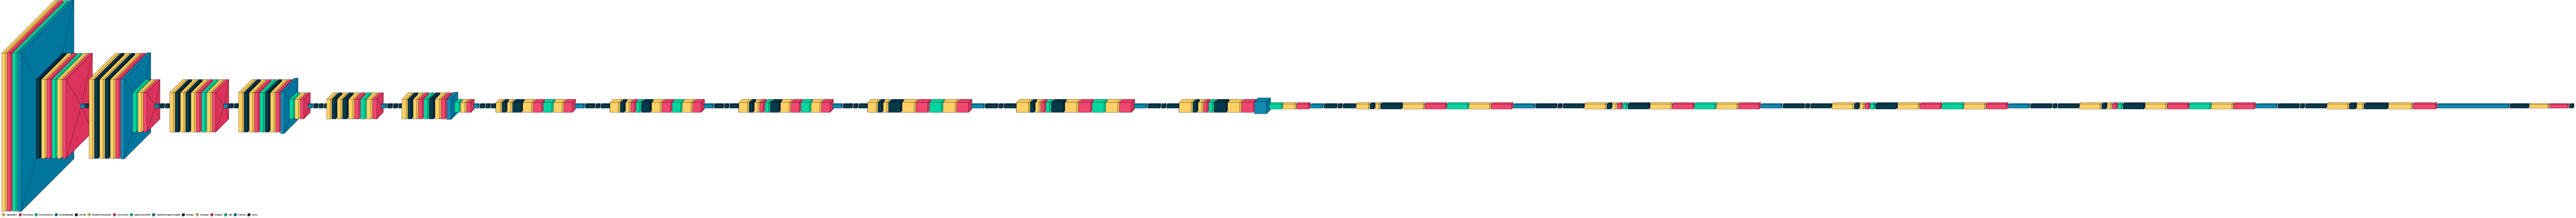

In [32]:
visualkeras.layered_view(model1,legend=True)

<a name="1"></a>
##  <span style="color:blue"> **import packages** </span>

In [1]:
import numpy as np
from math import pi
# import gc
# import pickle

#for model

import visualkeras
from tensorflow.math import exp,maximum,cos
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint ,EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, BatchNormalization , Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.test import is_built_with_cuda
# from tensorflow.keras.models import load_model

In [12]:
#for model evaluation and visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report,roc_curve,roc_auc_score, f1_score

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
is_built_with_cuda()

True

<a name="2"></a>
##  <span style="color:blue"> **prepare functions** </span>

<a name="2.1"></a>

In [2]:
# build train & validation generator 
def create_generators(train_path):
    train_datagen  = ImageDataGenerator(
#                                         rescale=1 / 255.0,
                                        rotation_range=30,
                                        zoom_range = 0.2,
                                        validation_split=0.25)

    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        color_mode = 'rgb',
        class_mode="binary",
        subset='training',
        shuffle=True,
    )

    valid_datagen=ImageDataGenerator(
#                                     rescale=1 / 255.0,
                                    validation_split=0.25)

    valid_generator = valid_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        color_mode = 'rgb',
        class_mode="binary",
        subset='validation',
        shuffle=False,
    )
    return train_generator ,valid_generator

<a name="2.2"></a>

In [3]:
def build_model():
    model = EfficientNetB0(include_top=False ,input_shape=(224,224,3) , weights="imagenet",drop_connect_rate=0.4)

    base_input= model.layers[0].input
    base_output= model.layers[-3].output
    
    l = Flatten()(base_output)
    
    l =Dense(units = 1024 ,activation='relu')(l)
    l=BatchNormalization()(l)
    l=Dropout(0.4)(l)
        
    final_output= Dense(units = 1 ,activation='sigmoid')(l)
    
    new_model= Model(inputs=base_input,outputs= final_output)
    return new_model

<a name="2.3"></a>

In [4]:
EPOCHS = 40

LEARNING_RATE = 3e-5
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE

LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 1
N_CYCLES = .5
 

In [5]:
# scadular for modifing learning rate during training
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + cos(pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = maximum(LR_MIN, lr)
            
    return lr         

<a name="2.4"></a>

In [6]:
def train_model(model, train_generator, valid_generator):
    
    checkpoint_filepath = './effnet/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8)
    
    callback = [LearningRateScheduler(lrfn),model_checkpoint_callback,es]
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history= model.fit(train_generator ,validation_data=(valid_generator) ,epochs=EPOCHS,callbacks=callback)
  
    return history

<a name="2.6"></a>

In [13]:
# graph of (train & validation) (accuracy & loss) per training epochs
def draw_train_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a name="2.7"></a>

In [14]:
# draw the confusion_matrix for testing data 
def draw_confusion_matrix(y_test ,y_pred):

    y_pred_rounded = np.around(y_pred)

    cf_matrix = confusion_matrix(y_test, y_pred_rounded)

    plt.figure(figsize = (10,7))
    sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')
    
    return y_pred_rounded

<a name="2.8"></a>

In [15]:
# print the classification_report for testing data 
def print_classification_report(y_test,  y_test_pred):
    
    target_names = ['abnormal', 'normal']
    print(classification_report(y_test,  y_test_pred,target_names=target_names))

<a name="2.9"></a>

In [16]:
#draw ROC curve
def draw_roc(y_test, y_pred):

    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)

    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

<a name="2.5"></a>

In [17]:
# D:\projects data\leukemia\testing
import pickle
x_test=pickle.load(open("D:/projects data/leukemia/testing/x_test.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/leukemia/testing/y_test.pkl', 'rb'))
# x_test = x_test/255.0

<a name="3"></a>
##  <span style="color:blue"> **train the model on the original data** </span>

<a name="3.1"></a>

### on original imbalanced data

<a name="3.1"></a>

In [9]:
train_path = "D:/projects data/leukemia/imbalanced/training"

In [10]:
train_generator,valid_generator = create_generators(train_path)

Found 7515 images belonging to 2 classes.
Found 2503 images belonging to 2 classes.


<a name="3.1.1"></a>

### build the model

In [11]:
model1 =build_model()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

<a name="3.1.2"></a>

### model complie & train

In [12]:
history=train_model(model1,train_generator,valid_generator)

Epoch 1/40
470/470 [==============================] - 134s 267ms/step - loss: 0.9966 - accuracy: 0.4933 - val_loss: 0.7914 - val_accuracy: 0.5433 - lr: 1.0000e-08
Epoch 2/40
470/470 [==============================] - 117s 249ms/step - loss: 0.7374 - accuracy: 0.7039 - val_loss: 0.5260 - val_accuracy: 0.7711 - lr: 1.5005e-05
Epoch 3/40
470/470 [==============================] - 95s 202ms/step - loss: 0.6123 - accuracy: 0.7630 - val_loss: 0.9939 - val_accuracy: 0.6632 - lr: 3.0000e-05
Epoch 4/40
470/470 [==============================] - 117s 250ms/step - loss: 0.4742 - accuracy: 0.8124 - val_loss: 0.3763 - val_accuracy: 0.8522 - lr: 3.0000e-05
Epoch 5/40
470/470 [==============================] - 96s 204ms/step - loss: 0.4103 - accuracy: 0.8362 - val_loss: 0.4532 - val_accuracy: 0.8214 - lr: 2.9946e-05
Epoch 6/40
470/470 [==============================] - 120s 255ms/step - loss: 0.3697 - accuracy: 0.8498 - val_loss: 0.2907 - val_accuracy: 0.8829 - lr: 2.9784e-05
Epoch 7/40
470/470 [====

<a name="3.1.3"></a>

### train & validation loss and accuracy per epochs

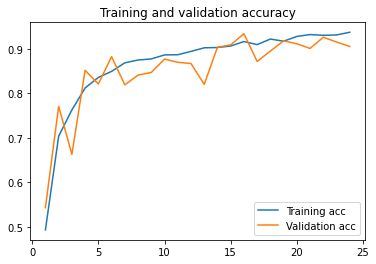

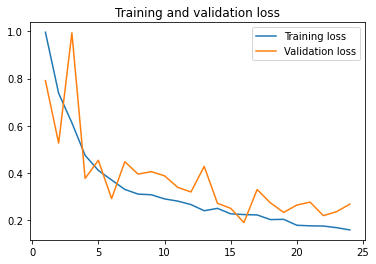

In [20]:
draw_train_graph(history)

<a name="3.1.4"></a>

### test results

In [25]:
model1.evaluate(x_test,y_test)

79/79 [==============================] - 6s 62ms/step - loss: 0.1936 - accuracy: 0.9279


[0.19360853731632233, 0.9278884530067444]

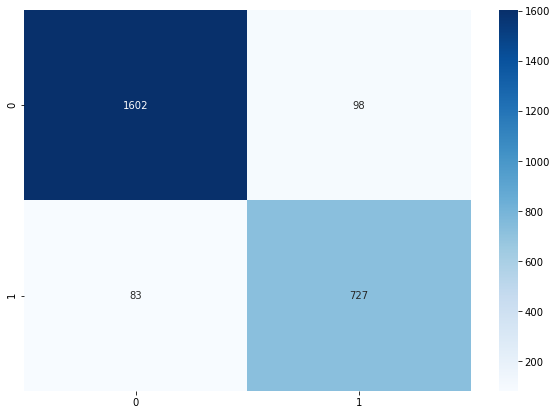

In [27]:
y_pred= model1.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [28]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

    abnormal       0.95      0.94      0.95      1700
      normal       0.88      0.90      0.89       810

    accuracy                           0.93      2510
   macro avg       0.92      0.92      0.92      2510
weighted avg       0.93      0.93      0.93      2510



In [29]:
f1_score(y_test,y_pred_rounded)

0.8892966360856269

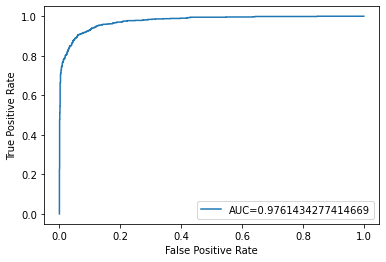

In [30]:
draw_roc(y_test,y_pred)

In [31]:
model1.save('efficientNet/effNet_model1_acc93.h5')

<a name="3.2"></a>

### model on oversampled data

In [8]:
train_path='D:/projects data/leukemia/oversampled'

In [9]:
train_generator ,valid_generator = create_generators(train_path)

Found 10188 images belonging to 2 classes.
Found 3394 images belonging to 2 classes.


<a name="3.2.1"></a>

### build the model

In [10]:
model2=build_model()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

<a name="3.2.2"></a>

### model complie & train

In [11]:
history= train_model(model2 ,train_generator ,valid_generator)

Epoch 1/40
637/637 [==============================] - 445s 683ms/step - loss: 0.9183 - accuracy: 0.5453 - val_loss: 0.9706 - val_accuracy: 0.4620 - lr: 1.0000e-08
Epoch 2/40
637/637 [==============================] - 152s 238ms/step - loss: 0.5656 - accuracy: 0.7862 - val_loss: 0.3028 - val_accuracy: 0.8984 - lr: 1.5005e-05
Epoch 3/40
637/637 [==============================] - 130s 204ms/step - loss: 0.5021 - accuracy: 0.8083 - val_loss: 0.3646 - val_accuracy: 0.8427 - lr: 3.0000e-05
Epoch 4/40
637/637 [==============================] - 131s 205ms/step - loss: 0.3846 - accuracy: 0.8476 - val_loss: 0.3507 - val_accuracy: 0.8695 - lr: 3.0000e-05
Epoch 5/40
637/637 [==============================] - 155s 243ms/step - loss: 0.3361 - accuracy: 0.8662 - val_loss: 0.3011 - val_accuracy: 0.9045 - lr: 2.9946e-05
Epoch 6/40
637/637 [==============================] - 133s 207ms/step - loss: 0.3115 - accuracy: 0.8705 - val_loss: 0.4211 - val_accuracy: 0.8951 - lr: 2.9784e-05
Epoch 7/40
637/637 [==

<a name="3.2.3"></a>

### train & validation loss and accuracy per epochs

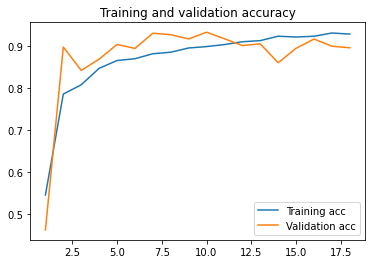

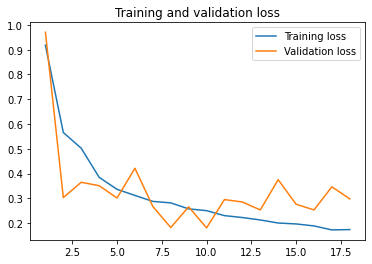

In [17]:
draw_train_graph(history)

<a name="3.2.4"></a>

### test results

In [25]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 6s 62ms/step - loss: 0.3144 - accuracy: 0.8904


[0.31441280245780945, 0.8904382586479187]

In [18]:
y_pred= model2.predict(x_test)

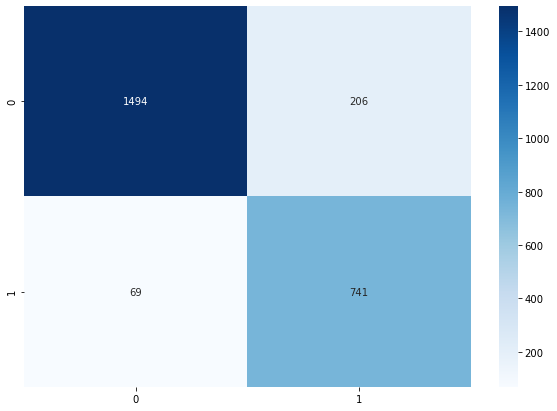

In [21]:
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [22]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

    abnormal       0.96      0.88      0.92      1700
      normal       0.78      0.91      0.84       810

    accuracy                           0.89      2510
   macro avg       0.87      0.90      0.88      2510
weighted avg       0.90      0.89      0.89      2510



In [23]:
f1_score(y_test,y_pred_rounded)

0.8434832100170746

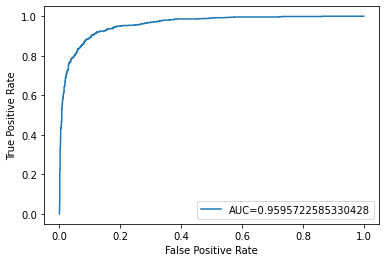

In [24]:
draw_roc(y_test,y_pred)

In [26]:
model2.save('efficientNet/effNet_model2_acc_89.h5')

<a name="3.3"></a>

### try the model on undersampled data

In [7]:
train_path='D:/projects data/leukemia/undersampled'

In [8]:
train_generator,valid_generator = create_generators(train_path)

Found 4842 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


<a name="3.3.1"></a>

### build the model

In [9]:
model3=build_model()
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

<a name="3.3.2"></a>

### model complie & train

In [10]:
history= train_model(model3 ,train_generator ,valid_generator)

Epoch 1/40
303/303 [==============================] - 202s 634ms/step - loss: 1.0250 - accuracy: 0.4872 - val_loss: 0.9083 - val_accuracy: 0.4553 - lr: 1.0000e-08
Epoch 2/40
303/303 [==============================] - 85s 279ms/step - loss: 0.7587 - accuracy: 0.6966 - val_loss: 0.7617 - val_accuracy: 0.7382 - lr: 1.5005e-05
Epoch 3/40
303/303 [==============================] - 86s 284ms/step - loss: 0.7123 - accuracy: 0.7323 - val_loss: 0.5491 - val_accuracy: 0.7773 - lr: 3.0000e-05
Epoch 4/40
303/303 [==============================] - 62s 204ms/step - loss: 0.5676 - accuracy: 0.7739 - val_loss: 0.5923 - val_accuracy: 0.8033 - lr: 3.0000e-05
Epoch 5/40
303/303 [==============================] - 86s 284ms/step - loss: 0.5032 - accuracy: 0.8055 - val_loss: 0.5120 - val_accuracy: 0.8139 - lr: 2.9946e-05
Epoch 6/40
303/303 [==============================] - 85s 280ms/step - loss: 0.4545 - accuracy: 0.8166 - val_loss: 0.4031 - val_accuracy: 0.8449 - lr: 2.9784e-05
Epoch 7/40
303/303 [=======

<a name="3.3.3"></a>

### train & validation loss and accuracy per epochs

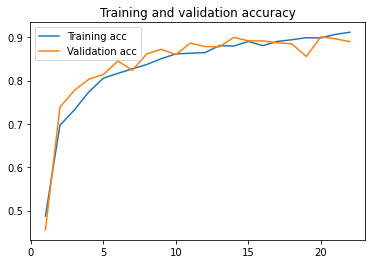

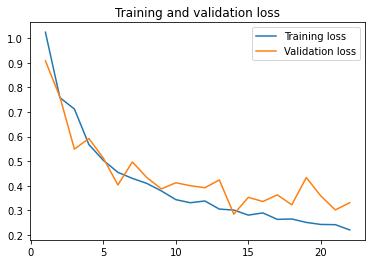

In [18]:
draw_train_graph(history)

<a name="3.3.4"></a>

### test results

In [24]:
model3.evaluate(x_test,y_test)

79/79 [==============================] - 6s 63ms/step - loss: 0.3684 - accuracy: 0.8781


[0.36839982867240906, 0.8780876398086548]

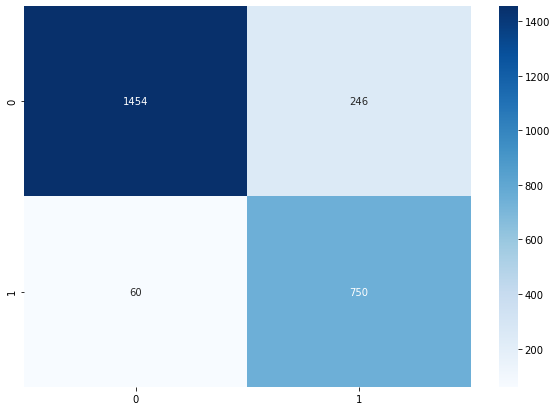

In [19]:
y_pred= model3.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [20]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

    abnormal       0.96      0.86      0.90      1700
      normal       0.75      0.93      0.83       810

    accuracy                           0.88      2510
   macro avg       0.86      0.89      0.87      2510
weighted avg       0.89      0.88      0.88      2510



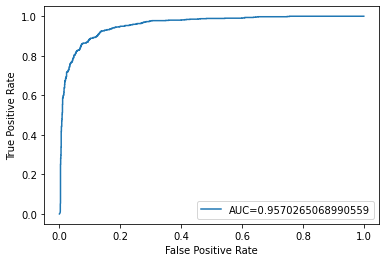

In [21]:
draw_roc(y_test,y_pred)

In [23]:
f1_score(y_test,y_pred_rounded)

0.8305647840531561

In [25]:
model3.save('efficientNet/effNet_model3_acc_88.h5')